# Nearest Neighbor Classifier
> Adapted from the CS231n coursework, by Nick Stanisha and Ryan Soklaski

In this notebook, we will step through the process of training a "nearest neighbor" classifier, using the CIFAR-10 dataset. CIFAR-10 is an academic dataset consisting of 60,000 32x32 RGB images. Each image belongs to one of ten different classes: 

 - airplane, class-id: 0
 - automobile, class-id: 1
 - bird, class-id: 2
 - cat, class-id: 3
 - deer, class-id: 4
 - dog, class-id: 5
 - frog, class-id: 6
 - horse, class-id: 7
 - ship, class-id: 8
 - truck, class-id: 9

10,000 of those images are "held out" as a test set, which is reserved for testing the quality of your classifier after your training process is complete.

Our goal here is to classify an unseen image based on its "proximity" to other, labeled images. Thus, we are assuming that two images are similar if their corresponding pixels have similar RGB values to one another. As described in the reading, we can utilize L2-distance to measure the proximity of images relative to one another.

Suppose an unlabeled image has a bunch of dark blue pixels along its bottom-half (water), a bunch of light-blue pixels along its top-half (sky), and a large white blob in the the middle. Then that image will likely have a small L2-distance with our labeled images containing ships, since those images will likely have a similar arrangement of pixel colors, more so than would a picture of a truck. If the image is indeed closer in proximity to labeled images of ships than it is to other classes of images, then our classifier will label the image as "ship" (i.e. assign it class-id 8).

More precisely, given our unlabeled image, we will consult its k-nearest neighbors (the k labeled images that have the smallest L2-distance with it). The most common label among those k labeled images will be used to classify the unlabeled images. Here, k is a positive integer that we select upfront. We will discuss what to do if there is a tie among the k labels later on in the notebook.  

So if k = 10, we will find the 10 labeled images the have the smallest L2 distance with our unlabeled image. Suppose that among those labeled images are 1 car, 3 birds, and 6 ships, then we will classify the unlabeled image as a ship.

In [9]:
# Execute this cell!
%matplotlib inline
import cifar10
import matplotlib.pyplot as plt
import numpy as np

## Understanding the data
Let's start by downloading and loading the cifar10's images and labels as numpy arrays

In [2]:
# Downloads the cifar10 dataset (unless the file
# already exists). This requires internet connectivity 
# and may take a couple of minutes to complete
if not cifar10.get_path().is_file():
    cifar10.download()
else:
    print("cifar10 is already downloaded at:\n{}".format(cifar10.get_path()))

Writing train data:
Images:  (50000, 3, 32, 32) uint8
Labels:  (50000,) int64
Writing test data:
Images:  (10000, 3, 32, 32) uint8
Labels:  (10000,) int64
Saving to: d:\myLaptop\GitHub\bwsi-machine-learning\Module02_YourFirstClassifier\nearest_neighbors\cifar10\cifar-10-python.npz


The cifar-10 images are saved as arrays of unsigned 8-bit numbers. We want to do arithmetic associated with non-integer values (i.e. taking the square root in the L2-distance), thus we will convert these arrays to store 32-bit floats.

In [3]:
x_train, y_train, x_test, y_test = (i.astype("float32") for i in cifar10.load())
x_train = x_train.transpose([0,2,3,1])
x_test = x_test.transpose([0,2,3,1])

cifar-10 loaded


In [4]:
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)
print('\n')
print('data type: {}'.format(x_train.dtype))
print('label type: {}'.format(y_train.dtype))

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


data type: float32
label type: float32


The training data is a 4D array with a shape of (50000, 32, 32, 3), corresponding to 50,000 images, each image comprised of a 32x32 array of RGB-values.

The training labels are a 1D array of the class-ID for each image. The class-IDs are integers 0-9, and are listed in correspondence with their associated word-labels above

Let's look at the first training image and its class-ID, and see that the label matches the content of the image. 

In [5]:
# the image is represented by a 32x32x3 array
x_train[0].shape

(32, 32, 3)

In [6]:
# accessing the class-label for image-0
y_train[0]

np.float32(6.0)

The class-ID of the first training image is 6. Referring back to the list at the beginning of the notebook, we see that this image contains a frog. Let's see that this is the case:

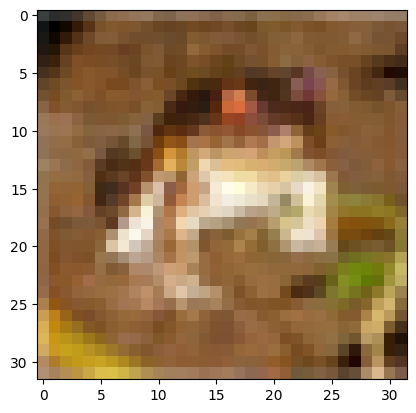

In [10]:
fig, ax = plt.subplots()
ax.imshow(x_train[0].astype("uint8"))

plt.show()

It is a frog! We are getting a handle on how the training data and labels correspond to each other. Now, let's plot a grid of images from the dataset.

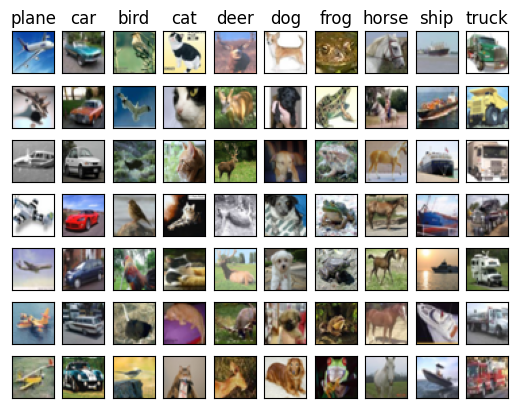

In [11]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
fig, axes = plt.subplots(nrows=samples_per_class, ncols=num_classes)

for label_ind, cls in enumerate(classes):
    idxs = np.where(y_train == label_ind)[0]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        axes[i, label_ind].imshow(x_train[idx].astype('uint8'))
        axes[i, label_ind].xaxis.set_major_locator(plt.NullLocator())
        axes[i, label_ind].yaxis.set_major_locator(plt.NullLocator())
        if i == 0:
            axes[i, label_ind].set_title(cls)
            

50,000 images is a good amount of data. For the sake of expediency, we will only use the first 5000 training images and 500 test images, respectively. If your computations are taking a long time, be sure to check that you executed this cell, and that you are indeed operating on this subset of data.

In [12]:
x_train, y_train = x_train[:5000], y_train[:5000]
x_test, y_test = x_test[:500], y_test[:500]
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (5000, 32, 32, 3)
Training labels shape:  (5000,)
Test data shape:  (500, 32, 32, 3)
Test labels shape:  (500,)


To compute the L2-distance between two images, we will want to flatten them out so that all of the RGB values of all their pixels of an image is in a 1-dimensional array. Thus each image will be a 3072-length 1D array (32x32x3 = 3072). Let's reshape our train/test data arrays to "flatten" each image. 

In [17]:
# shape-(5000, 32, 32, 3) -> shape-(5000, 3072)
x_train = np.reshape(x_train, (x_train.shape[0], -1))

# shape-(500, 32, 32, 3) -> shape-(500, 3072)
x_test = np.reshape(x_test, (x_test.shape[0], -1))
print("new train-shape:", x_train.shape)
print("new test-shape:", x_test.shape)

new train-shape: (5000, 3072)
new test-shape: (500, 3072)


In [14]:
# execute this cell after you have completed this function

def compute_distances(x: np.ndarray, y: np.ndarray):
    """ Write a function that computes the L2 distance between each row 
        in `x` and `y`.

        Parameters
        ----------
        x : numpy.ndarray
            x.shape must be (M, D)
            Each row of `x` is a flattened vector representing the pixel 
            values of a single image. Thus `x` represents
            M images, each one described by a length-D vector.

        y : numpy.ndarray
            y.shape must be (N, D)
            Each row of `y` is a flattened vector representing the pixel 
            values of a single image. Thus `y` represents
            N images, each one described by a length-D vector.

        Returns
        -------
        distances : numpy.ndarray
            distances.shape = (M, N)
            distances[i, j] = the L2 distance between x[i] and y[j]
    """
    # student code goes here
    M, D = x.shape
    N, D = y.shape

    dif = x.reshape((M, 1, D)) - y.reshape((1, N, D))
    
    return np.sqrt(np.sum(dif**2, axis=2))

In [15]:
from bwsi_grader.cogworks.nearest_neighbors import grade_distances
grade_distances(compute_distances)

Using grader version 1.12.0

============================== ALL TESTS PASSED! ===============================
Your submission code: bwf2cd8365978df692541a336a5faed94c3c40d76f49c18d04dd75f080



# Question 2
Let's use compute the distances between the images in `x_test` and `x_train`, and examine the resulting shape-(500, 5000) array.

** Use the output of the cells below to answer question 2 of the homework **

In [ ]:
# execute this cell

dists = compute_distances(x_test, x_train)
fig, ax = plt.subplots()
ax.imshow(dists, interpolation='none', cmap="gray")

# Question 3
Complete the code for the function `predict`, which, given the array of $M \times N$ distances, the labels, and k, predicts the M labels for the unlabeled images, based off of the labels of its k-nearest neighbors.

Suppose k=5. Given an unlabeled image, we want to identify the 5 labeled images that are nearest to it (based on L2-distance), and consult their labels (specifically their class-IDs for cifar10). The most common label will be selected as the label used to classify the unlabeled image. For example, suppose the labels for the 5 nearest neighbors are: 2, 0, 2, 2, 8. Then the predicted label for this unlabeled image will be 2. 

**If there is a tie among the k labels, the _lowest-value_ class-ID among the tied labels should be used.**

## Strategies
Test your approach on smaller data
 - Create your own N labeled images and M unlabeled images, and make up labels for the N images. Use small numbers, like M = 2, N = 5, D = 3, k=3
 - Compute the $M \times N$ distances and then, by hand, determine the labels among the k-nearest neighbors for each of the M images. And then label the M images accordingly. Does your code produce the same result?
 
The function [numpy.argsort](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html) will be useful. Also the `collections.Counter` object will likely come in handy here. 

### Examples
Given the distances of one unlabeled images with seven labeled images, we'll predict the label of the image based on `k=5` nearest neighbors

```python
>>> dists = np.array([[1., 0.1, 3., 2., 10., 1.5, 12.]])  # shape-(1, 7)
>>> labels = np.array([2,    0,  2,  2,  3,    8,  5])    # shape-(7,)
>>> predict(dists, labels, k=5)
array([2])
```

In [ ]:
def predict(dists, labels, k=1):
    """ Given a shape-(M, N) array of distances between M-unlabeled 
        and N-labeled images, and N labels, predict a label for each 
        of the M images based on its k-nearest neighbors.

        Parameters
        ----------
        dists : numpy.ndarray
            `dists.shape` must be (M, N) where M is the number of
            examples you wish to predict labels for, and N is 
            the number of labeled images used in the prediction
        
        labels : numpy.ndarray
            A shape-(N,) array of class-IDs, of labels for the N images.    

        Returns
        -------
        y_pred : numpy.array`
            A shape-(M,) array of class-IDs, as predicted by the k-nearest
            neighbors.
    """
    # student code goes here
    pass


In [ ]:
from bwsi_grader.cogworks.nearest_neighbors import grade_predict
grade_predict(predict)

# Visualizing the Classifier

The k-nearest-neighbor classifier is a fairly intuitive algorithm. Given a set of training data, to make a prediction on a new point we simply find the k nearest points (measured by L2-distance) and take the most common label among those. 

Unfortunately, the dimensionality of the CIFAR-10 data is too large (3072 dimensions!) to visualize classification process.

To remedy this lack of visualization capability, we'll create a simple dataset with 2D points . This will by our "toy dataset". Training points will be manually defined, with each point having a label. Each label will have a distinct color color. The test points will be sampled from the space -1 < x < 1 and -1  < y < 1.

In [ ]:
# create data points of shape (4, 2)
toy_x_train = np.array([[0.7, -0.7],
                       [-0.7, -0.7],
                       [0, 0.7],
                       [0, 0]
                      ])
# create class-labels of shape (4,)
toy_y_train = np.array([0, 1, 2, 3])

# define class colors 
toy_label_colors = {0: 'b',  # class 0 is blue
                    1: 'y',  # class 1 is yellow 
                    2: 'g',  # class 2 is green
                    3: 'r'}  # class 3 is is red

# Create a set of densly sampled points in the range [-1, 1]
xv, yv = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
toy_x_test = np.stack((xv, yv), axis=-1).reshape(-1, 2)

For ease of plotting, we'll define a function to plot our 2D data. 

In [ ]:
# run this cell
def plot_2d_data(x_train, y_train, x_test, test_predictions=np.empty(0)):
    """ Plot data color coded by class.
    
    Parameters
    ----------
    x_train : numpy.ndarray
        Training data of shape (N, 2).
    
    y_train : numpy.ndarray
        Training labels of shape (N,).
    
    x_test : numpy.ndarray
        Test data of shape (M, 2).
    
    test_predictions : numpy.ndarray, optional (default=np.array([]))
        Test predictions. If no argument is given the points 
        `x_test` are given the default color code.
    """
    # if no test predictions are given, use the default color
    # otherwise, find the corresponding class color
    if len(test_predictions) == 0:
        test_pt_colors = 'C0'
    else:
        test_pt_colors = [toy_label_colors[l] for l in test_predictions]
    fig, ax = plt.subplots()
    ax.scatter(*x_test.T, c=test_pt_colors, alpha=0.1)
    ax.scatter(*x_train.T, c=[toy_label_colors[l] for l in y_train])    

In [ ]:
# run this cell
plot_2d_data(toy_x_train, toy_y_train, toy_x_test)

Now, we'll apply the nearest neighbor classifier our toy dataset. The resulting color coded regions will display the **decision boundaries** found by the classifier 

In [ ]:
# run this cell
dists = compute_distances(toy_x_test, toy_x_train)
predictions = predict(dists, toy_y_train)
plot_2d_data(toy_x_train, toy_y_train, toy_x_test, predictions)

The decision boundaries produced by the classifier should have a nice geometric interpretation: this type of equal-area partitioning is known as a "_Voronoi Tessellation_".

Unfortunately, data encountered in the real world is not as simple as the data generated above. Let's introduce complexity by adding noise around the original points. This will be achieved by perturbing each truth point in the toy dataset with random values sampled from a Gaussian distribution. Each truth point from above will be augmented with several noise samples, the result will be a set of clusters.

In [ ]:
# run this cell
def generate_noisy_clusters(x, y, std=0.2, n_cluster_points=100):
    """ Generate clusters around data points by adding random noise.
    
    Parameters
    ----------
    x : numpy.ndarray
        Data points of shape (N, 2).
        
    y : numpy.ndarray
        Labels of data points `x` of shape (N,).
        
    std : float
        Standard deviation of noise used to generate clusters.
        
    n_cluster_points : int, optional (default=100)
        Number of data points to generate around each point in `x`.
        
    Returns
    -------
    Tuple[numpy.ndarray, numpy.ndarray]
        Arrays of shapes (`n_cluster_points`*N, 2) and (`n_cluster_points`*N,)
        Containing the data clusters and their labels.
    """
    toy_clusters_x = (np.repeat(x, n_cluster_points, axis=0) \
                      + std * np.random.randn(n_cluster_points*x.shape[0], 2)).clip(-1, 1)
    toy_clusters_y = np.repeat(y, n_cluster_points, axis=0)
    
    return toy_clusters_x, toy_clusters_y

In [ ]:
# run this cell
n_cluster_points = 100
moise_std = 0.2  # standard deviation of perturbations 
toy_clusters_x, toy_clusters_y = generate_noisy_clusters(toy_x_train, toy_y_train, moise_std, 
                                                         n_cluster_points)
# run this cell
plot_2d_data(toy_clusters_x, toy_clusters_y, toy_x_test)

In [ ]:
# run this cell
dists = compute_distances(toy_x_test, toy_clusters_x)
predictions = predict(dists, toy_clusters_y)
plot_2d_data(toy_clusters_x, toy_clusters_y, toy_x_test, predictions)

How do the results look compared to before the noise was added?  What happens when you change the standard deviation of the perturbations (experiment with this by changing the ``noise_std`` variable defined a few cells above)? 

You may have noticed that when we only use the single nearest neighbor outliers can easily cause incorrect classifications, leaving our classifier vulnerable to noise in the data. In the next section we'll look at a method to mitigate this problem.

But before we move on, let's inspect some results of the nearest neighbor classifier on a few images from CIFAR-10. 

We can't visualize the decision boundaries as we did above. Instead, we'll inspect the distances between test images and training images. By doing this, we can get a sense of what "proximity" looks like between images.

We'll create a small test set of one image and a training set of 10 images. The reduced size of the dataset will allow us observe L2-distances between images using the ``compute_distances`` and ``predict`` functions written earlier. We can determine what image in the training set is "closest" to the test image and thus what the classifier will predict.

In [ ]:
mini_train_set_idxs = range(11)
x_train_mini = x_train[mini_train_set_idxs]
y_train_mini = y_train[mini_train_set_idxs]

mini_test_set_idx = [11]
x_test_mini = x_train[mini_test_set_idx]
y_test_mini = y_train[mini_test_set_idx]

fig, ax = plt.subplots()
ax.imshow(x_test_mini.reshape(32, 32,  3).astype("uint8"))  # we flattened the images earlier 
ax.set_title(f'class: {classes[int(y_test_mini)]}')

In [ ]:
dists = compute_distances(x_train_mini, x_test_mini) 

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(dists), figsize=(8, 3))

fig.suptitle(f'Class and L2 distance to test image')
for label_ind, dist in enumerate(dists[:, 0]):
    axes[label_ind].imshow(x_train_mini[label_ind].astype('uint8').reshape(32, 32, 3))
    axes[label_ind].axis('off')
    axes[label_ind].set_title(f'{classes[int(y_train_mini[label_ind])]}\n{dist:1.0f}')

Given the above results, what class would be predicted for the test image (that's really a horse)? What in the images seem to make them "similar" to that test image?

# Motivating K-Nearest Neighbors

We've seen that the nearest neighbor algorithm is susceptible to outliers in our data, this was most tangibly observed on the toy dataset when we added noise. Let's see what happens when, instead of looking at only the first nearest neighbor, we consult the k nearest neighbors.

We'll begin by setting k=5.

In [ ]:
dists = compute_distances(toy_x_test, toy_clusters_x)
predictions = predict(dists, toy_clusters_y, k=5)

In [ ]:
plot_2d_data(toy_clusters_x, toy_clusters_y, toy_x_test, predictions)

How do the results of the KNN classifier compare to the results obtained from using just one neighbor when K=5, 15, 25? Is there a point when increasing K no longer becomes helpful?

# Choosing Hyperparameters

In this nearest-neighbor classification scheme, $k$, is a parameter that we must select prior to predicting labels for our unlabeled data. $k$ is never adjusted or optimized numerically by the classifier itself, thus it is distinguished as a "hyperparameter" of the classifier.

That being said, we still want to find a value for $k$, such that our classifier provides the most reliable labels for data that we have yet to encounter. Recall that `y_test` represents this "unseen" data. Any experimentation that we do to find a good value of $k$ should **not** involve any data from `y_test`. Once we settle on a final value for $k$, we can then measure the final accuracy of our classifier on this "new" data, to measure its generalized performance.

The process for finding a good value for $k$, then, will have to involve only data and labels from our designated training set. Here we will make use of a strategy known as "cross-validation", for identifying good hyperparameter values, without relying on your test data. 

In cross validation, the training data is separated into $n$ equal-sized segments, which are known as "folds". To evaluate the accuracy of our classifier, for a given value of $k$, we use the following process: 
- Hold out one fold as the unlabeled data, and use the remaining $n-1$ folds as the labeled data. The held-out fold is called the "validation fold"
- Record the accuracy of the classifier by seeing how well the predicted-labels for the validation fold match their actual labels.
- Repeat this process a total of $n$ times, such that each fold is used as a validation fold.

By the end of this process, $n$ classifier-accuracies will be recorded, given that value of $k$ (1 one for each validation fold). We can use this to compute the average accuracy for that k-nearest neighbor classifier.

We can thus use cross-validation to evaluate our nearest neighbor classifier's accuracy for a variety of values of $k$. The best-performing $k$ will be used when we want to classify data that we genuinely do not have labels for. 

In the following cells, you will provide code that:
- splits the training data and labels into folds for cross validation
- for a given value of k, records the classifier accuracies for all n validation folds

You will likely want to make use of the numpy functions "vstack" and "concatenate" to form the data and labels for the train-folds when each validation-fold is held out.

## Question 4: Making 'folds' of data

Now we will write a simple function that can be used to split both our training data and our labels into "folds", so that we can perform the cross-validation process described above.

Write a function that takes in an $n$-dimensional array (where $n > 0$), the desired number of folds $f$, and returns a list containing $f$ **equal-sized** folds. This means that some elements of the array might be excluded from the folds. Each fold should be created by slicing the array along axis-0. 






### Examples
```python
>>> x = np.array([1, 2, 3, 4, 5, 6])

>>> make_folds(x, num_folds=1)
[array([1, 2, 3, 4, 5, 6])]

>>> make_folds(x, num_folds=2)
[array([1, 2, 3]), array([4, 5, 6])]

>>> make_folds(x, num_folds=3)
[array([1, 2]), array([3, 4]), array([5, 6])]

>>> make_folds(x, num_folds=4)
[array([1]), array([2]), array([3]), array([4])]

>>> y = array([[ 0,  1],
...            [ 2,  3],
...            [ 4,  5],
...            [ 6,  7],
...            [ 8,  9],
...            [10, 11]])

>>> make_folds(y, 2)
[array([[0, 1],
        [2, 3],
        [4, 5]]), 
 array([[ 6,  7],
        [ 8,  9],
        [10, 11]])]
```

In [ ]:
def make_folds(x, num_folds):
    """ Divides the array `x` along axis-0 into a list of equal-sized 
    sub-arrays.
    
    Parameters
    ----------
    x : numpy.ndarray, shape=(N, ...)
        An array of one or more dimensions, to be split along axis-0
    
    num_folds : int 
        The number of equal-sized folds to split `x` into. 
        Assume that: 0 < num_folds <= N.
    
    Returns
    -------
    List[numpy.ndarray]
        A list of the sub-divided arrays"""
    # student code goes here
    pass

In [ ]:
from bwsi_grader.cogworks.nearest_neighbors import grade_make_folds
grade_make_folds(make_folds)

Now, we will the lists `x_train_folds` and `y_train_folds`.

`x_train_folds` is a list that should store consecutive slices
of the training data, creating equal-sized grouping of images. 
I.e. `x_train_folds[0]` should return the
array corresponding to fold-0 of the data.

`y_train_folds` is a list that should store the corresponding labels for each fold.
I.e. `y_train_folds[0]` should return an array containing the labels
for fold-0 of the data.

In [ ]:
# execute this cell

# we will be using 5 fold in our cross-validation
num_folds = 5
x_train_folds = make_folds(x_train, num_folds=num_folds)
y_train_folds = make_folds(y_train, num_folds=num_folds)

# we want to evaluate our classifier's accuracy
# for the following values of k
k_values = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

You will now perform cross-validation analysis to find an ideal k-value for your classifier.

 For each k-value, measure the n-accuracies of the classifier,
 one for each validation fold, and save the 
 k -> [acc_1, acc_2, ..., acc_n] mapping in the `accuracies`
 dictionary.

Use `compute_distances` to produce the MxN distances between
the the M "unlabeled" images and the N "labeled" images.
Feed this array of distances, the N labels, and k into
`predict` to produce (M,) predicted labels for the "unlabeled"
images

Compare the M predicted labels against the M true labels
and measure the accuracy of the classifier: num_correct / M

For each time you hold out one of your n folds for validation,
 you will need to form a single array out of your n-1 folds
 of training (labeled) data, holding out whichever fold is being used as the validation (unlabeled) data. Similarly, you will need to form a single array of the corresponding labels of the $n-1$ training folds. `numpy.concatenate` will be valuable here. Look up its documentation.
 
This process needs to be performed every time you hold out a different validation fold. 

```
# cross-validation pseudo-code
for fold_i in range(num_folds):
    validation_data = fold_i-array selected from list-of-folds; 
                      shape-(M, D) array
    labeled_data = the other folds "stacked together" as one array; 
                   shape-(N, D) array
    validation_labels = labels for fold-i; shape-(M,) array
    labels = labels for remaining data; shape-(N,) array

    for k in k_values:
        - Predict the M-labels for the validation fold, using 
          k-nearest neighbors with the shape-(N, D) labeled_data.
            -- You will need to compute the distance between the pairs 
               of validation-data and labeled-data.
        - Compute the classification accuracy by comparing against the 
          actual labels for the validation data.
                   
        - The dictionary `accuracies` should store a list in 
          association with each k value. k -> list_of_accuracies
          -- Append this accuracy to the list associated with this 
             k value.
             
accuracy =  (number of correctly assigned labels) 
           ----------------------------------------
           (total number of labels assigned; i.e. M)
```

In [ ]:
# Accuracies is a dictionary that must map the k-value
# to the resulting list of n classifier accuracies, one
# accuracy for each validation fold.
accuracies = {}  # maps k -> [acc_1, acc_2, ..., acc_n]


## STUDENT CROSS VALIDATION CODE GOES HERE ##
# execute this cell once completed

In [ ]:
# execute this cell
# this will check if you recorded the appropriate
# number of fold-accuracies, for each k-value
assert sorted(accuracies) == k_values
for list_of_acc in accuracies.values():
    assert len(list_of_acc) == num_folds

In [ ]:
# execute this cell to plot the n accuracies, for each k-value, along
# with the average accuracy.

fig, ax = plt.subplots()
for k in k_values:
    ax.scatter([k] * len(accuracies[k]), accuracies[k], marker="x")

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(accuracies.items())])
ax.errorbar(k_values, accuracies_mean, yerr=accuracies_std, label="mean accuracy")
ax.set_title('Cross-validation on k')
ax.set_xlabel('k')
ax.set_ylabel('Cross-validation accuracy')
ax.grid(True)
ax.legend()

You can use the buttons at the bottom-left portion of the image to zoom in on parts of the plot. When hovering your cursor over the plot, the (x,y) coordinate of the cursor will be displayed at the bottom-right portion of the plot. 


Use your recorded accuracies to answer Question 4a and 4b.

In [ ]:
# Question 4 STUDENT CODE GOES HERE
all_acc = list()
for k in accuracies:
    all_acc.extend(accuracies[k])
print(max(all_acc))
print(min(all_acc))

Identify the optimal value for $k$ (the k-value with the best mean accuracy), evaluate the nearest neighbor classifier on the test-data (as the unlabeled data) and the training data (as the labeled data), and record its accuracy. You will be asked to report this "test accuracy" to three decimal places in Question 5.

In [ ]:
# Question 5 STUDENT CODE GOES HERE
k = 10
dists = compute_distances(x_test, x_train)
labels = predict(dists, y_train, k)
acc = np.mean(labels == y_test)
round(float(acc), 3)

How does this test accuracy compare to the mean validation accuracy? Did the cross-validation process lead us to find a k-value such that our classifier performed "as expected" on data that it had never encountered before? Although you will not be asked to submit an answer for these questions, it is important that you are able to answer them clearly. 